# Counting legal moves


**TO DO**
- train model with max pooling on the binary problem, where I know it works, if possible all the way to 100% accuracy; this is a proof-of-principle showing that the model is good; maybe save intermediate versions at different accuracies?
- try to solve the counting problem using *transfer learning*: copy the convolutional layers of the solution to the previous problem, then add a different tail with average instead of max pooling (might work better if we also strip off the last conv layer, or at least its bias)

In [ ]:
from MorpionSolitaire import *
from DeepLearningMS import *

In [ ]:
from multiprocess import Pool
pool = Pool()

## Mini-batches

This function plays one game at random until there are no more moves, then rewinds the game to an arbitrary interemediate stage, and returns the final grid.

The label $y$ is related to the number of legal moves $N$ by the equation
$$
    y = \frac{N}{N + 5}
$$
so that it is equal to zero if there are no moves, and approaches one if there are many moves.

In [ ]:
def play_one_game(host = 0): # dummy argument needed for passing to pool.map
    game = NewGame('cross').play()
    game = game.unplay(np.random.randint(game.score + 1))
    n = len(game.moves)
    return game.grid.image(), n / (n + 5)

Mini-batches contains a certain number of grids obtained in the way described above (computed in parallel to gain time), as well as a labels (0 for no legal moves, 1 for at least one legal move).

In [ ]:
def generate_batch(batch_size = 200):
    xy = pool.map(play_one_game, range(batch_size))
    x = torch.tensor(np.array([e[0] for e in xy])).float().unsqueeze(1)
    y = torch.tensor([e[1] for e in xy]).unsqueeze(1)
    return x, y

20,000 grids and labels computed in this way are saved once and for all:

In [ ]:
# xy = pool.map(play_one_game, range(20000))
# np.save('data/counting_problem_grids.npy', np.stack([e[0] for e in xy]))
# np.save('data/counting_problem_labels.npy', np.stack([e[1] for e in xy]))

## Data frame

**Possible improvement (?):** reduce the value of `repeat` to 8 (or even lower).
This slows down the training process but it might increase its accuracy.

In [ ]:
data = MSDataFrame(batch_size = 200, length = 100,
                   batch_fct = generate_batch, repeat = 16,
                   data = 'data/counting_problem_grids.npy',
                   labels = 'data/counting_problem_labels.npy')
data.info()

Number of mini-batches stored: 100
Number of mini-batches created: 0


In [ ]:
x, y = data.data[0]
x.shape, y.shape

(torch.Size([200, 1, 94, 94]), torch.Size([200, 1]))

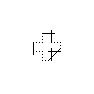

In [ ]:
MSvisualize(x[0])

In [ ]:
y[0]

tensor([0.7917])

In [ ]:
5.0 * y[0] / (1.0 - y[0])

tensor([19.0000])

Distribution of labels:

In [ ]:
ydata = torch.cat([data.data[i][1].squeeze() for i in range(len(data.data))])
ndata = torch.round(5.0 * ydata / (1.0 - ydata))
nmax = ndata.max().int().item()
ndistribution = [torch.where(ndata == i, 1.0, 0.0).mean().item() for i in range(nmax + 1)]

In [ ]:
ydata.mean(), ydata.std(), ydata.min(), ydata.max()

(tensor(0.6357), tensor(0.1900), tensor(0.), tensor(0.8684))

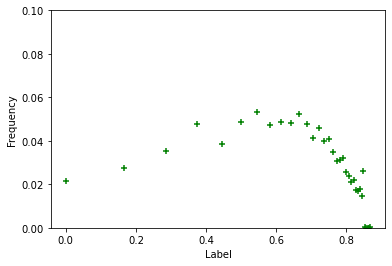

In [ ]:
plt.scatter([y / (y + 5) for y in range(nmax + 1)], ndistribution, color='green', marker = '+')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xlim(-0.03, 1)
plt.ylim(0, 0.1)
plt.show()

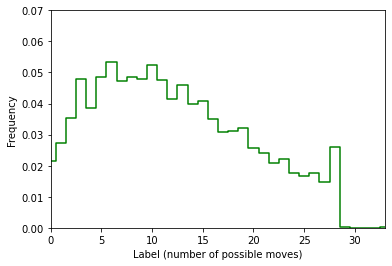

In [ ]:
plt.step(np.array(range(nmax + 1)), ndistribution, where='mid', color='green')
plt.xlabel('Label (number of possible moves)')
plt.ylabel('Frequency')
plt.xlim(0, nmax)
plt.ylim(0, 0.07)
# plt.savefig('blog/Part_4_Counting_images/labels_counting.png', bbox_inches='tight')
plt.show()

### Accuracy

The accuracy is computed after inverting the relation between the label $y$ and the corresponding number of moves $N$:
$$
N = \frac{5 y}{1 - y}
$$
The value $N_\text{output}$ computed from the network output is rounded to the nearest integer, and compared with the label $N_\text{label}$ (also rounded to nearest integer to avoid numerical inaccuracies). The function `accuracy` counts how many times the two integer match. The functions `plusminusone` and `plusminustwo` count how many times $N_\text{output}$ and $N_\text{label}$ differ at most by one or two units.

In [ ]:
def accuracy(outputs, labels, plusminus = 0.0):
    noutputs = torch.round(5.0 * outputs / (1.0 - outputs))
    nlabels = torch.round(5.0 * labels / (1.0 - labels))
    return torch.where(torch.abs(noutputs - nlabels) <= plusminus, 1.0, 0.0).mean()

In [ ]:
def plusminusone(outputs, labels):
    return accuracy(outputs, labels, plusminus = 1.0)
def plusminustwo(outputs, labels):
    return accuracy(outputs, labels, plusminus = 2.0)

## Model and training

We use *transfer learning*: instead of training the model from scratch (which seems nearly impossible), we use a model pre-trained on the binary problem:

In [ ]:
net = torch.load('models/Descartes_binary.pt')
net.train()
net

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(20, 40, kernel_size=(2, 2), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (9): ReLU()
  (10): AdaptiveAvgPool2d(output_size=1)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=40, out_features=20, bias=True)
  (13): ReLU()
  (14): Linear(in_features=20, out_features=10, bias=True)
  (15): ReLU()
  (16): Linear(in_features=10, out_features=1, bias=True)
)

**Possible modification:** we could also try to freeze all parameters of the convolutional layers and only train the last 3 linear layers (this does not seem to work though)

In [ ]:
# for i in range(10):
#     for param in net[i].parameters():
#         param.requires_grad = False

**Other possible modification:** we could also modify the linear layer part of the network:

In [ ]:
# modules = [net[i] for i in range(12)]
# modules.extend([torch.nn.Linear(40, 10),
#                 torch.nn.ReLU(),
#                 torch.nn.Linear(10, 4),
#                 torch.nn.ReLU(),
#                 torch.nn.Linear(4, 1)])
# net = torch.nn.Sequential(*modules)
# net

Number of parameters in the model:

In [ ]:
sum(p.numel() for p in net.parameters())

23801

Number of trainable parameters in the model (only relevant with freezing):

In [ ]:
# sum(p.numel() for p in net.parameters() if p.requires_grad)

In [ ]:
y_pred = net(x)
y_pred.shape

torch.Size([200, 1])

In [ ]:
accuracy(y_pred, y), plusminusone(y_pred, y), plusminustwo(y_pred, y)

(tensor(0.0250), tensor(0.0300), tensor(0.0300))

## Training

In [ ]:
running_loss_data = []
accuracy_data = []

Remark: in this case we changed optimizer from SGD to Adam

In [ ]:
data.train_model(net, n_epochs = 300, lr=0.001, optim = 'Adam',
                 accuracy_func = [accuracy, plusminusone, plusminustwo],
                 loss_monitoring = running_loss_data,
                 accuracy_monitoring = accuracy_data)

[0]  loss: 0.00008  accuracy: 0.81  0.98  0.99  
[1]  loss: 0.00004  accuracy: 0.88  1.00  1.00  
[2]  loss: 0.00004  accuracy: 0.86  0.99  1.00  
[3]  loss: 0.00004  accuracy: 0.87  1.00  1.00  
[4]  loss: 0.00004  accuracy: 0.86  0.99  1.00  
[5]  loss: 0.00004  accuracy: 0.82  0.99  1.00  
[6]  loss: 0.00004  accuracy: 0.86  0.99  1.00  
[7]  loss: 0.00004  accuracy: 0.87  0.99  1.00  
[8]  loss: 0.00004  accuracy: 0.85  0.99  1.00  
[9]  loss: 0.00003  accuracy: 0.87  1.00  1.00  
[10]  loss: 0.00004  accuracy: 0.85  0.99  1.00  
[11]  loss: 0.00003  accuracy: 0.89  1.00  1.00  
[12]  loss: 0.00003  accuracy: 0.88  0.99  1.00  
[13]  loss: 0.00003  accuracy: 0.89  1.00  1.00  
[14]  loss: 0.00003  accuracy: 0.88  0.99  1.00  
[15]  loss: 0.00003  accuracy: 0.88  1.00  1.00  
[16]  loss: 0.00003  accuracy: 0.89  1.00  1.00  
[17]  loss: 0.00003  accuracy: 0.88  1.00  1.00  
[18]  loss: 0.00003  accuracy: 0.88  1.00  1.00  
[19]  loss: 0.00013  accuracy: 0.74  0.95  0.98  
[20]  loss

[163]  loss: 0.00001  accuracy: 0.94  1.00  1.00  
[164]  loss: 0.00002  accuracy: 0.89  1.00  1.00  
[165]  loss: 0.00002  accuracy: 0.92  1.00  1.00  
[166]  loss: 0.00002  accuracy: 0.92  1.00  1.00  
[167]  loss: 0.00002  accuracy: 0.92  1.00  1.00  
[168]  loss: 0.00002  accuracy: 0.92  1.00  1.00  
[169]  loss: 0.00002  accuracy: 0.93  1.00  1.00  
[170]  loss: 0.00002  accuracy: 0.91  1.00  1.00  
[171]  loss: 0.00002  accuracy: 0.92  1.00  1.00  
[172]  loss: 0.00002  accuracy: 0.91  1.00  1.00  
[173]  loss: 0.00002  accuracy: 0.91  1.00  1.00  
[174]  loss: 0.00002  accuracy: 0.90  1.00  1.00  
[175]  loss: 0.00002  accuracy: 0.91  1.00  1.00  
[176]  loss: 0.00001  accuracy: 0.93  1.00  1.00  
[177]  loss: 0.00001  accuracy: 0.94  1.00  1.00  
[178]  loss: 0.00002  accuracy: 0.91  1.00  1.00  
[179]  loss: 0.00002  accuracy: 0.91  1.00  1.00  
[180]  loss: 0.00002  accuracy: 0.92  1.00  1.00  
[181]  loss: 0.00001  accuracy: 0.94  1.00  1.00  
[182]  loss: 0.00001  accuracy:

In [ ]:
# torch.save(net, 'models/Descartes_improved.pt')

In [ ]:
data.info()

Number of mini-batches stored: 100
Number of mini-batches created: 3748


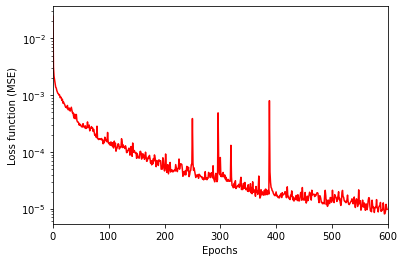

In [ ]:
plt.plot(running_loss_data, color='red')
plt.xlabel('Epochs')
plt.xlim(0, 600)
plt.ylabel('Loss function (MSE)')
plt.yscale('log')
# plt.savefig('blog/Part_4_Counting_images/Descartes_loss.png', bbox_inches='tight')
plt.show()

In [ ]:
accuracy_data = np.array(accuracy_data)

In [ ]:
accuracy_data[295:300]

array([[0.8751 , 0.9946 , 0.99955],
       [0.60715, 0.85825, 0.9254 ],
       [0.79235, 0.9828 , 0.99715],
       [0.8636 , 0.9963 , 0.99945],
       [0.862  , 0.9963 , 0.9994 ]])

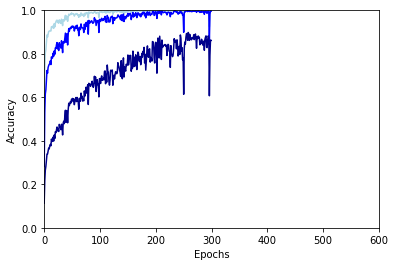

In [ ]:
plt.plot(accuracy_data[:,2], color='lightblue')
plt.plot(accuracy_data[:,1], color='blue')
plt.plot(accuracy_data[:,0], color='darkblue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0, 600)
plt.ylim(0, 1)
# plt.savefig('blog/Part_4_Counting_images/Descartes_accuracy.png', bbox_inches='tight')
plt.show()

In [ ]:
error_data = 1.0 - accuracy_data

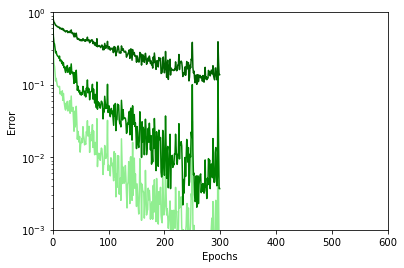

In [ ]:
plt.plot(error_data[:,2], color='lightgreen')
plt.plot(error_data[:,1], color='green')
plt.plot(error_data[:,0], color='darkgreen')
plt.xlabel('Epochs')
plt.xlim(0, 600)
plt.ylabel('Error')
plt.ylim(0.001,1)
plt.yscale('log')
plt.show()

## Loading the model

Once the model has been trained, this can be used to load its state dictionary:

In [ ]:
net2 = torch.load('models/Descartes_improved.pt')
net2.eval()

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(20, 40, kernel_size=(2, 2), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (9): ReLU()
  (10): AdaptiveAvgPool2d(output_size=1)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=40, out_features=20, bias=True)
  (13): ReLU()
  (14): Linear(in_features=20, out_features=10, bias=True)
  (15): ReLU()
  (16): Linear(in_features=10, out_features=1, bias=True)
)

## Validation

In [ ]:
x, y = generate_batch(1000)

In [ ]:
y_preds = net2(x).data

In [ ]:
accuracy(y_preds, y)

tensor(0.9390)

In [ ]:
plusminusone(y_preds, y)

tensor(1.)

In [ ]:
plusminustwo(y_preds, y)

tensor(1.)

In [ ]:
y.mean(), y.std(), y_preds.mean(), y_preds.std()

(tensor(0.6334), tensor(0.1834), tensor(0.6343), tensor(0.1837))

In [ ]:
n = 5.0 * y / (1.0 - y)
n_preds = 5.0 * y_preds / (1.0 - y_preds)
n[0:10], n_preds[0:10]

(tensor([[12.0000],
         [24.0000],
         [17.0000],
         [ 5.0000],
         [ 8.0000],
         [22.0000],
         [21.0000],
         [ 2.0000],
         [ 7.0000],
         [ 5.0000]]),
 tensor([[11.9209],
         [24.2866],
         [17.3069],
         [ 4.9040],
         [ 8.1319],
         [21.9331],
         [21.0416],
         [ 2.0186],
         [ 7.0359],
         [ 4.9282]]))

In [ ]:
mistakes = [i for i in range(y.shape[0])
            if torch.abs(n[i] - n_preds[i]) >= 0.5]

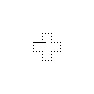

In [ ]:
MSvisualize(x[mistakes[0]])

In [ ]:
[n[i] for i in mistakes]

[tensor([27.]),
 tensor([25.0000]),
 tensor([16.0000]),
 tensor([27.]),
 tensor([27.]),
 tensor([17.0000]),
 tensor([26.0000]),
 tensor([26.0000]),
 tensor([28.0000]),
 tensor([28.0000]),
 tensor([28.0000]),
 tensor([25.0000]),
 tensor([17.0000]),
 tensor([28.0000]),
 tensor([27.]),
 tensor([17.0000]),
 tensor([27.]),
 tensor([16.0000]),
 tensor([28.0000]),
 tensor([26.0000]),
 tensor([27.]),
 tensor([16.0000]),
 tensor([18.]),
 tensor([27.]),
 tensor([28.0000]),
 tensor([28.0000]),
 tensor([16.0000]),
 tensor([27.]),
 tensor([27.]),
 tensor([24.0000]),
 tensor([24.0000]),
 tensor([28.0000]),
 tensor([27.]),
 tensor([27.]),
 tensor([27.]),
 tensor([28.0000]),
 tensor([28.0000]),
 tensor([28.0000]),
 tensor([27.]),
 tensor([27.]),
 tensor([28.0000]),
 tensor([16.0000]),
 tensor([28.0000]),
 tensor([26.0000]),
 tensor([27.]),
 tensor([28.0000]),
 tensor([28.0000]),
 tensor([25.0000]),
 tensor([17.0000]),
 tensor([28.0000]),
 tensor([16.0000]),
 tensor([16.0000]),
 tensor([17.0000]),
 ten

## Inference

To verify how good the model is, we can test it on a type of grid that it has never seen before:

In [ ]:
game = NewGame('pipe')
x = torch.tensor(game.grid.image()).float().unsqueeze(0).unsqueeze(0)
n = len(game.moves)

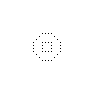

In [ ]:
MSvisualize(x)

In [ ]:
n

24

In [ ]:
y = net2(x).data
5.0 * y / (1.0 - y)

tensor([[23.3625]])

In [ ]:
game = game.play(depth = 10)
x = torch.tensor(game.grid.image()).float().unsqueeze(0).unsqueeze(0)
n = len(game.moves)

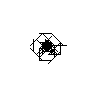

In [ ]:
MSvisualize(x)

In [ ]:
n

5

In [ ]:
y = net2(x).data
5.0 * y / (1.0 - y)

tensor([[4.7883]])